In [78]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

## Visualize the datasets

Plot the dust deposition rate of the empirical dataset in the measurement locations and the simulated data on the global grid.

In [79]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

In [80]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [81]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Generate a map plot of dust deposition based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the dust deposition data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str, optional): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - measure_units (str, optional): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return


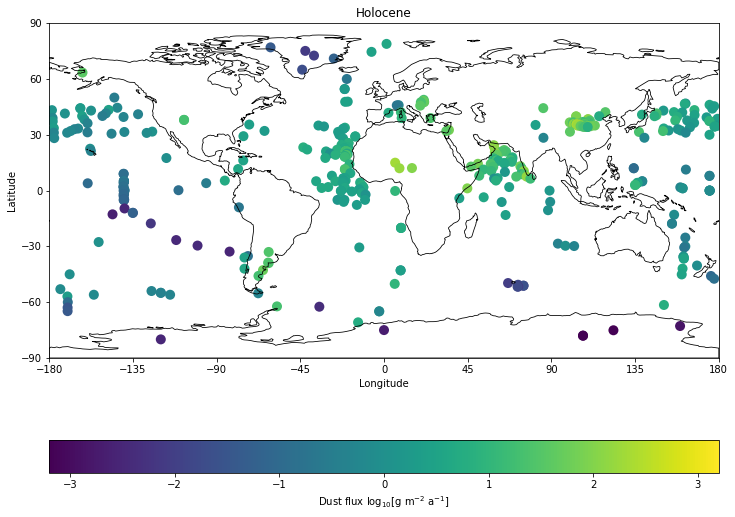

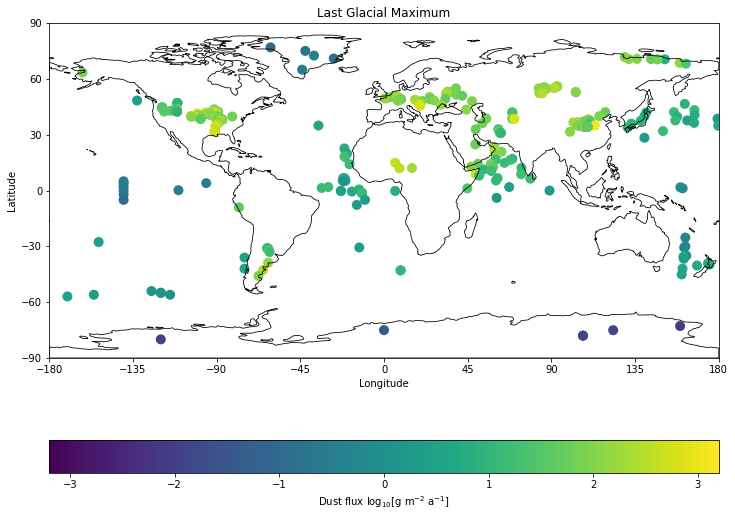

In [82]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_LGM')

## Create and visualize the global grid

The global grid for the predictions consists of 3-degree spacing.

In [83]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

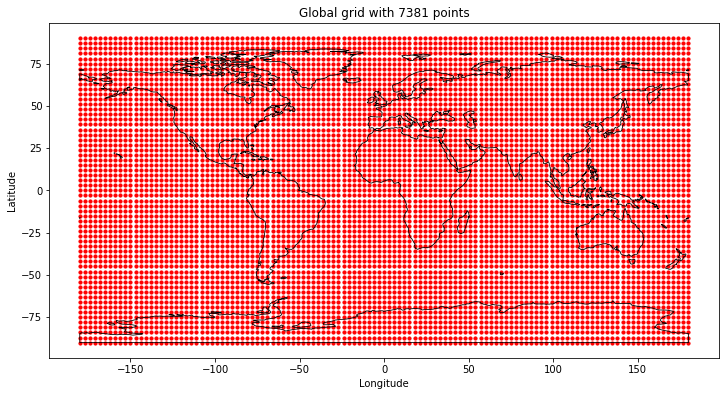

In [84]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='red', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

## Analyse global deposition rate with nearest neighbours

The dust deposition rate will be estimated by averaging the values of the $k$ nearest neigbours.

In [85]:
def distance_euclidean(x, y):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

In [86]:
def distance_geodesic(x, y):
    """
    Calculate the geodesic distance between two points on Earth.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    R = 6371 #Radio medio de la Tierra en kilómetros

    lat1, lon1 = np.radians(x[1]), np.radians(x[0])
    lat2, lon2 = np.radians(y[1]), np.radians(y[0])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

*Aquí utilicé Chat GPT para saber cuando y como convertir las coordenadas de los puntos de grados a radianes.

In [87]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Perform a k nearest neighbour estimation.

    Parameters:
    df : pandas.DataFrame
        The database.
    x : Iterable
        Location for the estimation.
    k : int
        The number of neighbours to consider.
    dist : str
        The type of distance definition.
    """
    
    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean
    
    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))
    
    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]
    
    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)
    
    return estimation

In [88]:
# Choose the number of neighbours to include in the estimation
n_neighbours = 5

Calculamos solo con distancia geodésica y visualizamos:

In [89]:
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid["est_hol"] = estimations_holocene
df_global_grid["est_lgm"] = estimations_lgm

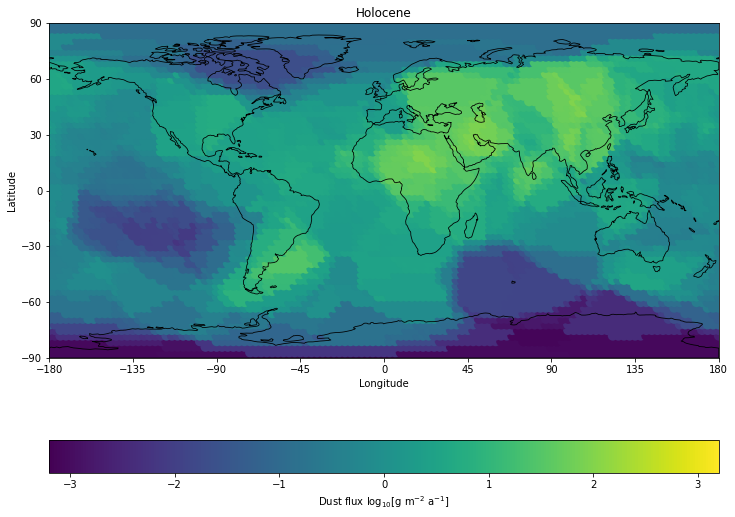

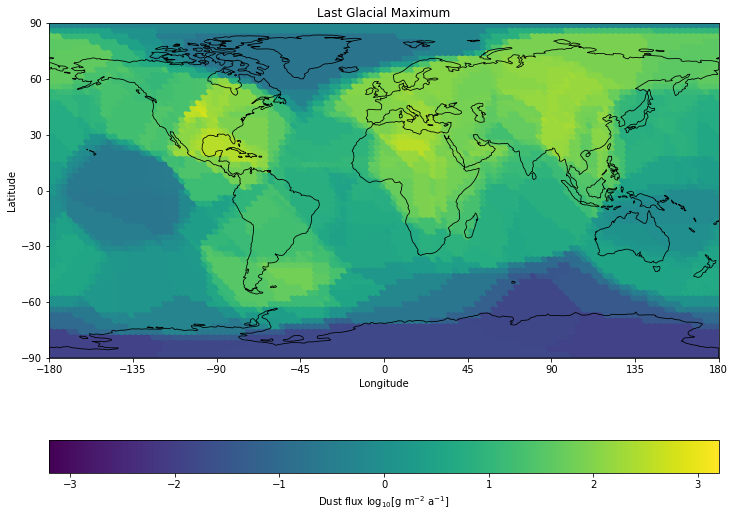

In [90]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

Ahora, calculamos la diferencia de ambos métodos (Euclidiana y Geodésica) y la visualizamos:

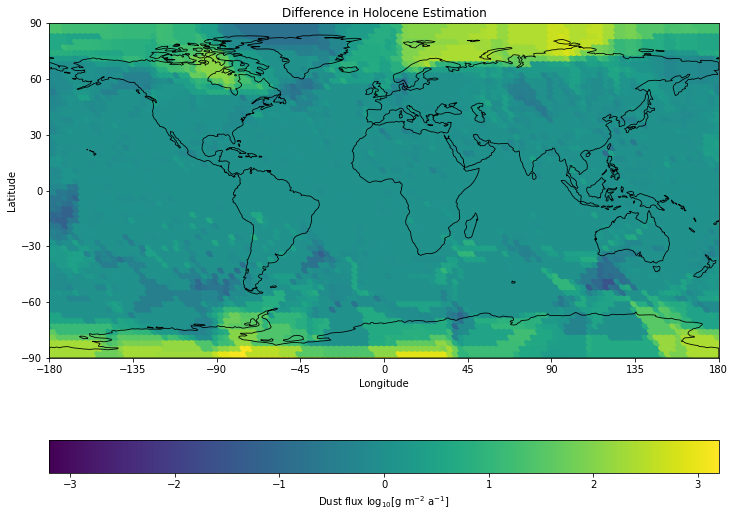

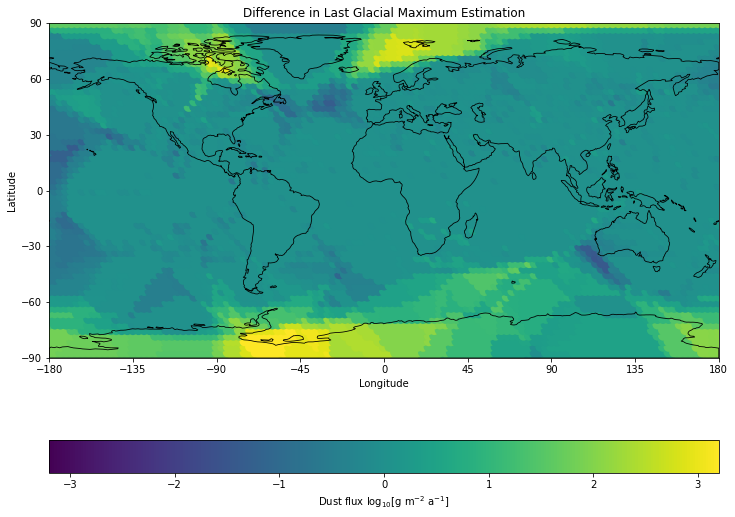

In [91]:
#Distancia euclidiana
estimations_holocene_euclidean = df_global_grid.apply(lambda row: nearest_neighbour_estimation(df_empirical_Holocene, (row["lon"], row["lat"]), n_neighbours, dist='euclidean'), axis=1)
estimations_lgm_euclidean = df_global_grid.apply(lambda row: nearest_neighbour_estimation(df_empirical_LGM, (row["lon"], row["lat"]), n_neighbours, dist='euclidean'), axis=1)

#Distancia geodésica
estimations_holocene_geodesic = df_global_grid.apply(lambda row: nearest_neighbour_estimation(df_empirical_Holocene, (row["lon"], row["lat"]), n_neighbours, dist='geodesic'), axis=1)
estimations_lgm_geodesic = df_global_grid.apply(lambda row: nearest_neighbour_estimation(df_empirical_LGM, (row["lon"], row["lat"]), n_neighbours, dist='geodesic'), axis=1)

#Diferencia entre las estimaciones de los dos métodos
difference_holocene = estimations_holocene_euclidean - estimations_holocene_geodesic
difference_lgm = estimations_lgm_euclidean - estimations_lgm_geodesic

df_global_grid["difference_holocene"] = difference_holocene
df_global_grid["difference_lgm"] = difference_lgm

#Visualizamos
plot_dust_deposition_map(df=df_global_grid,
                         title='Difference in Holocene Estimation',
                         name_to_save='DIFFERENCE_MAP_HOLOCENE',
                         label_str='difference_holocene')

plot_dust_deposition_map(df=df_global_grid,
                         title='Difference in Last Glacial Maximum Estimation',
                         name_to_save='DIFFERENCE_MAP_LGM',
                         label_str='difference_lgm')

*Aquí utilicé Chat GPT para calcular ambas distancias de manera que el código no fuera tan largo (lambda)


Finalmente, calculamos las estimaciones con ambos métodos para compararlos y visualizar ambos mapas.

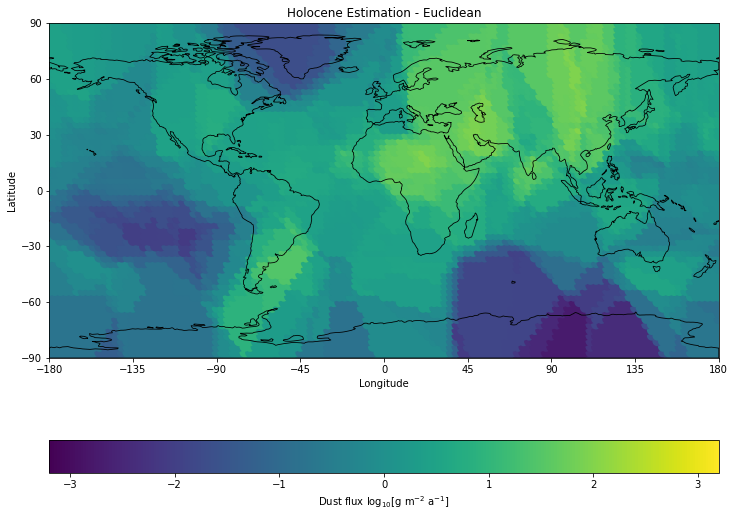

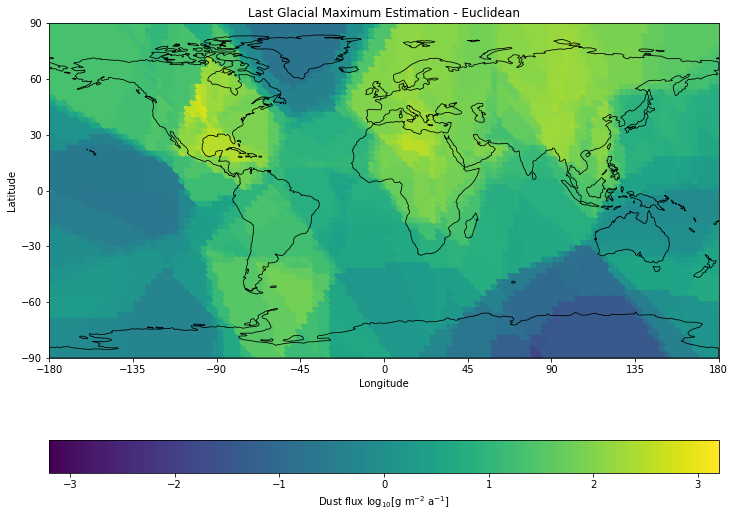

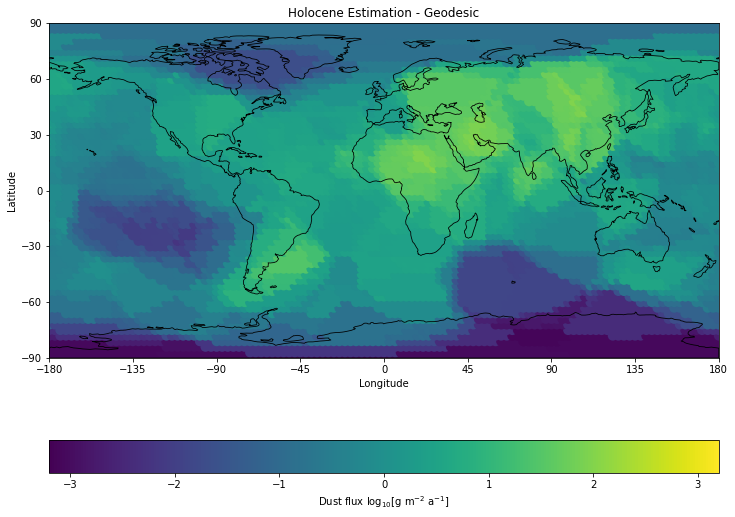

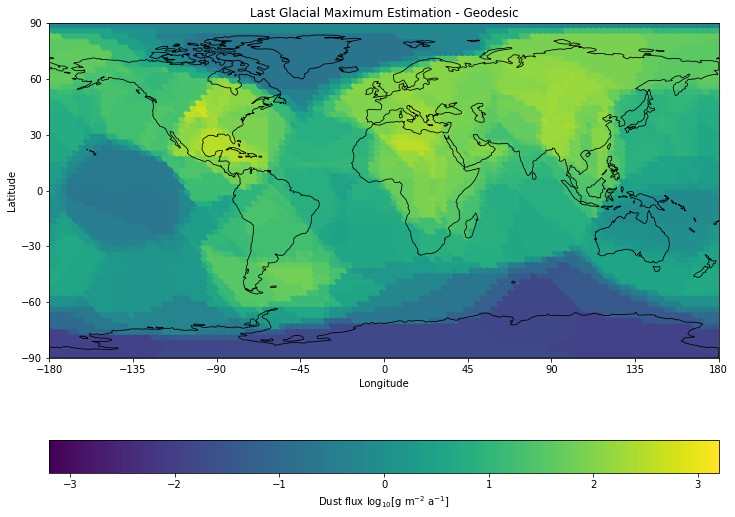

In [92]:
#Calculamos las estimaciones utilizando ambos métodos
estimations_holocene_euclidean = df_global_grid.apply(lambda row: nearest_neighbour_estimation(df_empirical_Holocene, (row["lon"], row["lat"]), n_neighbours, dist='euclidean'), axis=1)
estimations_lgm_euclidean = df_global_grid.apply(lambda row: nearest_neighbour_estimation(df_empirical_LGM, (row["lon"], row["lat"]), n_neighbours, dist='euclidean'), axis=1)

estimations_holocene_geodesic = df_global_grid.apply(lambda row: nearest_neighbour_estimation(df_empirical_Holocene, (row["lon"], row["lat"]), n_neighbours, dist='geodesic'), axis=1)
estimations_lgm_geodesic = df_global_grid.apply(lambda row: nearest_neighbour_estimation(df_empirical_LGM, (row["lon"], row["lat"]), n_neighbours, dist='geodesic'), axis=1)

df_global_grid["est_hol_euclidean"] = estimations_holocene_euclidean
df_global_grid["est_lgm_euclidean"] = estimations_lgm_euclidean
df_global_grid["est_hol_geodesic"] = estimations_holocene_geodesic
df_global_grid["est_lgm_geodesic"] = estimations_lgm_geodesic

#Visualizamos
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene Estimation - Euclidean',
                         name_to_save='ESTIMATION_MAP_HOLOCENE_EUCLIDEAN',
                         label_str='est_hol_euclidean')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum Estimation - Euclidean',
                         name_to_save='ESTIMATION_MAP_LGM_EUCLIDEAN',
                         label_str='est_lgm_euclidean')

plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene Estimation - Geodesic',
                         name_to_save='ESTIMATION_MAP_HOLOCENE_GEODESIC',
                         label_str='est_hol_geodesic')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum Estimation - Geodesic',
                         name_to_save='ESTIMATION_MAP_LGM_GEODESIC',
                         label_str='est_lgm_geodesic')

Respondemos:

**a)** ¿Por qué las diferencias son más grandes en una parte que otra parte del mundo?

Las diferencias pueden ser más grandes en ciertas partes del mundo debido a la variabilidad en la densidad de puntos de datos que hay en esas áreas. Si hay mayor concentración de puntos de datos cerca de un punto de estimación, es más probable que los métodos de vecinos cercanos produzcan estimaciones más precisas y similares entre sí. Por otro lado, en áreas con pocos datos disponibles, las estimaciones pueden ser más susceptibles a la variabilidad entre los métodos.

**b)** ¿Cuál método es más fidedigno en los polos sur y norte?

La distancia geodésica es más fidedigna que la euclidiana ya que tiene en cuenta la curvatura de la Tierra. Además, en los polos sur y norte, donde las líneas de longitud convergen, la distancia euclidiana entre dos puntos puede ser muy diferente a la distancia real en la superficie de la Tierra.

**c)** ¿Cuál método es más fidedigno en longitud 180◦?

En la longitud 180°, la distancia euclidiana puede ser engañosa debido a la discontinuidad que se produce al trazar líneas rectas en un mapa plano. Por otro lado, la distancia geodésica considera la curvatura de la Tierra y proporciona mediciones más precisas en esta región.

**d)** ¿Cuáles son las diferencias entre los resultados para el Holoceno y el LGM?

Las diferencias entre los resultados para el Holoceno y el LGM pueden ser grandes debido a los cambios climáticos y ambientales que ocurrieron entre estos períodos. Durante el LGM, las condiciones climáticas eran considerablemente diferentes de las del Holoceno, lo que puede haber afectado la distribución y el transporte de polvo en la atmósfera, y por lo tanto, las estimaciones resultantes pueden variar entre los períodos.

**e)** ¿Cómo elegir el número de vecinos cercanos?

La elección del número de vecinos cercanos depende de varios factores, como la distribución espacial de los datos, la variabilidad en las condiciones ambientales y la precisión deseada en las estimaciones. En general, se puede elegir un número de vecinos cercanos mayor para áreas con mayor densidad de datos y menor variabilidad, mientras que se puede usar un número menor de vecinos cercanos en áreas con menos datos y mayor variabilidad.